Throug this notebook, we will work on the following object :
Analysis of customer reviews of the Trianon Rive Gauche hotel to gain insights into key issues impacting the hotel ratings.

We collected data from Booking.com and TripAdvisor (separated into 2 data cleaning parts) to obtain a more comprehensive understanding of customer experiences and sentiments. This dual-source approach allows us to identify consistent trends, key issues, and unique insights across different platforms to improve the hotel's services and overall guest satisfaction.

# Booking.com Data


## Data Import

In [ ]:
pip install googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=cbd061e4ee1f7e85a9a7270219e0d9f0d8ac25acad974e0d33faadb2a226a0e2
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

In [2]:
import re
import locale
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from googletrans import Translator
from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_excel("sample_data/hotel_reviews_trianon_rive_gauche.xlsx")
df.head()

,Content,Country,Score,Positive,Negative,Date
0,Rien à redire,La Réunion,Avec une note de 10,"Propre, l’emplacement, personnel et la literie...",Rien,Commentaire envoyé le 16 août 2024
1,Bien,France,"Avec une note de 7,0",Normal pour un 4 étoiles,"L'isolation phonique. On entend les voisins, s...",Commentaire envoyé le 13 septembre 2024
2,Fabuleux,France,"Avec une note de 9,0",L'emplacement le prix posé en dernière minute ...,NaN,Commentaire envoyé le 10 septembre 2024
3,Super séjour !,France,"Avec une note de 8,0",Chambre confortable et très propre. Petit déje...,NaN,Commentaire envoyé le 5 septembre 2024
4,mérite d'être bien noté surtout pour l'emplace...,Tunisie,"Avec une note de 8,0",Très bon emplacement\nBon petit déjeuner en sa...,douche vraiment petite,Commentaire envoyé le 29 août 2024


## Data Cleaning

I first convert the content of 'Date' column into a valid date format.






In [ ]:
months_map = {
    'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04',
    'mai': '05', 'juin': '06', 'juillet': '07', 'août': '08',
    'septembre': '09', 'octobre': '10', 'novembre': '11', 'décembre': '12'
}

def replace_french_month(date_str):
    for french_month, month_num in months_map.items():
        if french_month in date_str:
            return date_str.replace(french_month, month_num)
    return date_str
date_value_example = df["Date"][1]
df['Date'] = df['Date'].apply(replace_french_month)
df['Date'] = df['Date'].str.extract(r'envoyé le (\d{1,2} \w+ \d{4})')[0]
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y', errors='coerce')

commentary = f"Previous Date value : {date_value_example} \
 \nBecomes : {df['Date'][1].strftime('%Y-%m-%d')}"
print(commentary)

Previous Date value : Commentaire envoyé le 13 septembre 2024  
Becomes : 2024-09-13


### Mapping countries with associated region done with the use of text generative AI

In [ ]:
regions_mapping = {
    'La Réunion': 'Africa',
    'France': 'Europe',
    'Tunisie': 'Africa',
    'Guadeloupe': 'North America',
    'Belgique': 'Europe',
    'Finlande': 'Europe',
    'Sénégal': 'Africa',
    'Saint-Martin (Antilles françaises)': 'North America',
    'Martinique': 'North America',
    'Canada': 'North America',
    'Algérie': 'Africa',
    'Suisse': 'Europe',
    'Île Maurice': 'Africa',
    'Maroc': 'Africa',
    'Portugal': 'Europe',
    'Luxembourg': 'Europe',
    'Gabon': 'Africa',
    'Allemagne': 'Europe',
    'Polynésie française': 'Oceania',
    'Turquie': 'Asia',
    'Émirats arabes unis': 'Asia',
    'République démocratique du Congo': 'Africa',
    'Espagne': 'Europe',
    'Liban': 'Asia',
    'Brésil': 'South America',
    'Côte-d\'Ivoire': 'Africa',
    'Pays-Bas': 'Europe',
    'Corée du Sud': 'Asia',
    'États-Unis': 'North America',
    'Roumanie': 'Europe',
    'Royaume-Uni': 'Europe',
    'Irlande': 'Europe',
    'Australie': 'Oceania',
    'Afrique du Sud': 'Africa',
    'Hongrie': 'Europe',
    'Estonie': 'Europe',
    'Philippines': 'Asia',
    'Arménie': 'Asia',
    'République tchèque': 'Europe',
    'Italie': 'Europe',
    'Norvège': 'Europe',
    'Autriche': 'Europe',
    'Slovaquie': 'Europe',
    'Pologne': 'Europe',
    'Ukraine': 'Europe',
    'Nouvelle-Zélande': 'Oceania',
    'République dominicaine': 'North America',
    'Argentine': 'South America',
    'Inde': 'Asia',
    'Russie': 'Europe',
    'Albanie': 'Europe',
    'Hong Kong': 'Asia',
    'Israël': 'Asia',
    'Islande': 'Europe',
    'Lettonie': 'Europe',
    'Lituanie': 'Europe',
    'Japon': 'Asia',
    'Chine': 'Asia',
    'Géorgie': 'Asia',
    'Serbie': 'Europe',
    'Malte': 'Europe',
    'Égypte': 'Africa',
    'Singapour': 'Asia',
    'Danemark': 'Europe',
    'Chypre': 'Europe',
    'Bermudes': 'North America',
    'Iran': 'Asia',
    'Taïwan': 'Asia',
    'Croatie': 'Europe',
    'Azerbaïdjan': 'Asia',
    'Qatar': 'Asia',
    'Malaisie': 'Asia',
    'Kenya': 'Africa',
    'Biélorussie': 'Europe',
    'Mexique': 'North America',
    'Irak': 'Asia',
    'Suède': 'Europe',
    'Bahreïn': 'Asia',
    'Monténégro': 'Europe',
    'Bulgarie': 'Europe',
    'Slovénie': 'Europe',
    'Nigeria': 'Africa',
    'Paraguay': 'South America',
    'Pakistan': 'Asia',
    'Grèce': 'Europe',
    'Arabie Saoudite': 'Asia',
    'Colombie': 'South America',
    'Guatemala': 'North America',
    'Indonésie': 'Asia',
    'Oman': 'Asia',
    'Koweït': 'Asia',
    'Fidji': 'Oceania',
    'Kazakhstan': 'Asia',
    'Uruguay': 'South America',
    'Pérou': 'South America',
    'Chili': 'South America',
    'Équateur': 'South America',
    'Bolivie': 'South America',
    'Ouzbékistan': 'Asia',
    'Vénézuela': 'South America',
    'Thaïlande': 'Asia',
    'Costa Rica': 'North America',
    'Groenland': 'North America',
    'Cameroun': 'Africa',
    'Gambie': 'Africa',
    'Nouvelle-Calédonie': 'Oceania',
    'Kirghizistan': 'Asia',
    'Mongolie': 'Asia',
    'Jordanie': 'Asia',
    'Bosnie-Herzégovine': 'Europe',
    'Porto Rico': 'North America',
    'Panama': 'North America',
    'Bangladesh': 'Asia',
    'Soudan': 'Africa',
    'Turkmenistan': 'Asia',
    'Moldavie': 'Europe',
    'Îles Féroé': 'Europe',
    'Andorre': 'Europe'
}

### Figures to visualize data

In [ ]:
df["Country"].nunique()

118

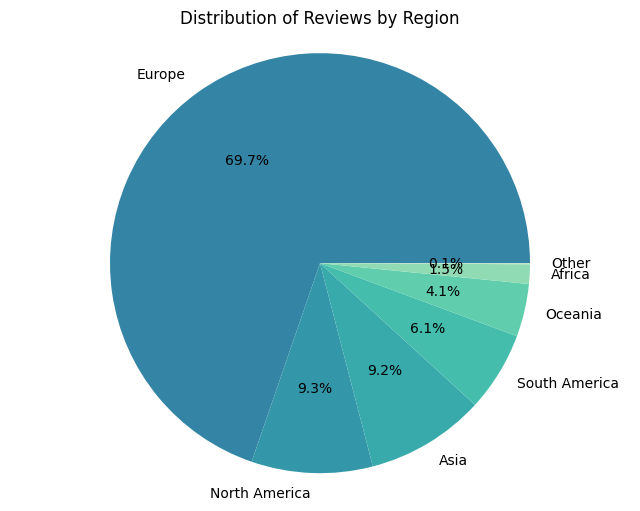

In [ ]:
df['Region'] = df['Country'].map(regions_mapping)
df['Region'].fillna('Other', inplace=True)
region_counts = df['Region'].value_counts()

palette = sns.color_palette("mako", n_colors=len(region_counts)*2)[len(region_counts):]

plt.figure(figsize=(8, 6))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', colors=palette)
plt.title('Distribution of Reviews by Region')
plt.axis('equal')
plt.show()


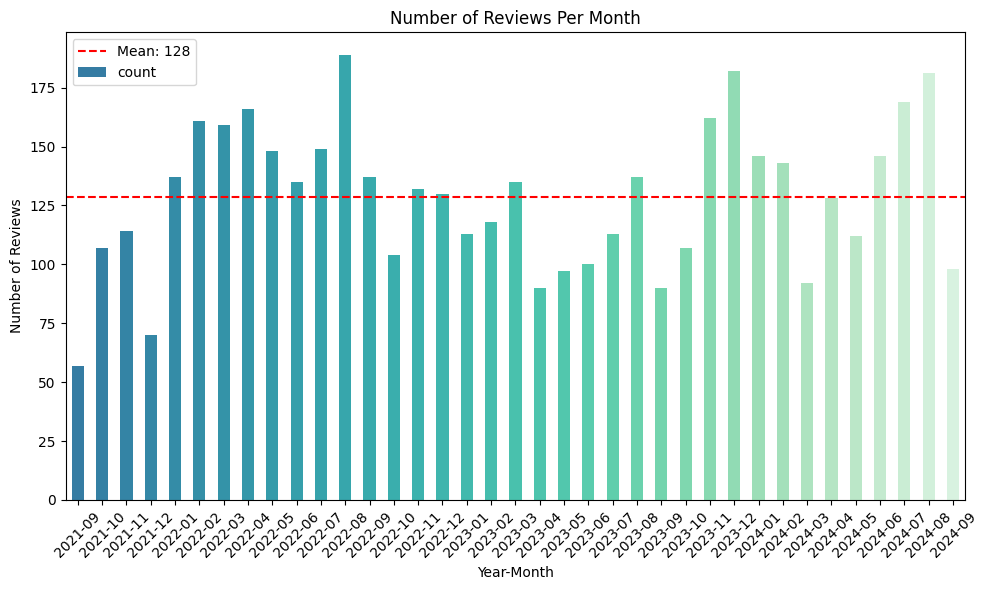

In [ ]:
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m')
reviews_per_month = df['YearMonth'].value_counts().sort_index()

palette = sns.color_palette("mako", n_colors=len(reviews_per_month)*2)[len(reviews_per_month):]

plt.figure(figsize=(10, 6))
reviews_per_month.plot(kind='bar', color=palette)

mean_reviews_per_month = reviews_per_month.mean()
plt.axhline(y=mean_reviews_per_month, color='red', linestyle='--', label=f'Mean: {mean_reviews_per_month:.0f}')

plt.title('Number of Reviews Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Then I do the same for 'Score' column.

In [ ]:
score_value_example = df['Score'][1]
df['Score'] = df['Score'].str.extract(r'(\d+)')[0]
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
df['Score'] = df['Score'].astype('Int64')

commentary = f"Previous Score value : {score_value_example} \
 \nBecomes : {df['Score'][1]}"
print(commentary)

Previous Score value : Avec une note de 7,0  
Becomes : 7


The values that will be parsed are in 'Negative' column. This is why I need to translate all the rows in a same language. Here, we will chose English.

In [ ]:
import pandas as pd
from googletrans import Translator
from time import sleep

df.dropna(subset=['Negative'], inplace=True)
df = df[~df['Negative'].str.lower().isin(['rien', 'ras'])]

translator = Translator()

def translate_text(text, dest='en'):
    sleep(1) # 1-second delay to deal with the limited amount of requests of Translator() object.
    try:
        translation = translator.translate(text, dest=dest)
        return translation.text
    except Exception as e:
        print(f"Erreur lors de la traduction : {e}")
        return text

df['Translated_Neg'] = df['Negative'].progress_apply(lambda x: translate_text(x, dest='en'))

100%|██████████| 2052/2052 [36:28<00:00,  1.07s/it]


In a second term, I clean the text to remove unnecessary punctuation in order to simplify the analysis.

I additionnaly remove reviews that contain 'Nothing' word because they are useless.




In [ ]:
df = df[~df['Translated_Neg'].str.contains('nothing', case=False, na=False)]

def clean_text(text):
    text = text.lower()
    text = text.replace("’", " ")
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

df['Translated_Neg'] = df['Translated_Neg'].astype(str)

df['Clean_Neg'] = df['Translated_Neg'].apply(clean_text)

Here, I apply tokenization and lemmatization. A lemmatization is the process of reducing words to their base form so that variations of a word are grouped in a single word (ex: 'rooms' will become 'room').

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Clean_Neg'] = df['Clean_Neg'].apply(preprocess_text)

df['Clean_Neg'] = df['Clean_Neg'].replace("nan", np.nan)
df.dropna(subset=['Clean_Neg'], inplace=True)

# TripAdvisor Data

## Data Import

In [ ]:
import re
import locale
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from googletrans import Translator
from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df = pd.read_csv("hotel_trianon_reviews.csv", sep=";")
df.head()

,Review,Rating
0,Nous avons passé un très bon séjour dans cet h...,4.0
1,Excellente prestation pour cet hôtel qui mérit...,5.0
2,Pour un 4 * La chambre est vieillotte petite e...,3.0
3,"En déplacement professionnel sur Paris, j'ai c...",5.0
4,le petit dejeuner est tres bien et le personne...,3.0


## Data Cleaning

Handling 'Score' columns :


*   Changing name 'Rating' into 'Score'
*   Modifying the values into integers instead of 1-decimal floats.



In [ ]:
df.rename(columns={'Rating': 'Score'}, inplace=True)
df['Score'] = df['Score'].astype('Int64') * 2

The values that will be parsed are in 'Negative' column. This is why I need to translate all the rows in a same language. Here, we will choose English.

In [ ]:
import pandas as pd
from googletrans import Translator
from time import sleep

df.dropna(subset=['Review'], inplace=True)
df = df[~df['Review'].str.lower().isin(['rien', 'ras'])]

translator = Translator()

def translate_text(text, dest='en'):
    sleep(0.5) # very small delay to deal with the limited amount of requests of Translator() object.
    try:
        translation = translator.translate(text, dest=dest)
        return translation.text
    except Exception as e:
        print(f"Erreur lors de la traduction : {e}")
        return text

df['Translated_Rev'] = df['Review'].progress_apply(lambda x: translate_text(x, dest='en'))

100%|██████████| 583/583 [06:41<00:00,  1.45it/s]


Differenciating negative from positive reviews. As we use only negative reviews to chek what is wrong, we don't need positive ones.

Nb: TextBlob only works on english sentances, that's why we process it after translating.

In [ ]:
from textblob import TextBlob

In [ ]:
print(f"Mean before getting rid of positive reviews : {df['Score'].mean()}")
print(f"Size before getting rid of positive reviews : {df['Score'].size}")

Mean before getting rid of positive reviews : 7.807890222984563
Size before getting rid of positive reviews : 583


In [ ]:
tqdm.pandas()
df['Sentiment'] = df['Translated_Rev'].apply(lambda x: 'NEGATIVE' if TextBlob(x).sentiment.polarity <= 0.2 else 'POSITIVE')
df = df[df['Sentiment'] == 'NEGATIVE']


In [ ]:
print(f"Mean after getting rid of positive reviews : {df['Score'].mean()}")
print(f"Size after getting rid of positive reviews : {df['Score'].size}")

Mean after getting rid of positive reviews : 6.388888888888889
Size after getting rid of positive reviews : 216


In [ ]:
df.head()

,Review,Score,Translated_Rev,Sentiment
2,Pour un 4 * La chambre est vieillotte petite e...,6,For a 4 * the bedroom is old little and not su...,NEGATIVE
4,le petit dejeuner est tres bien et le personne...,6,"Breakfast is very good and the staff nice, clo...",NEGATIVE
6,Comme j'ai réservé au dernier moment j'ai eu d...,10,As I reserved at the last moment I was entitle...,NEGATIVE
10,Malheureusement plusieurs problèmes liés notre...,6,Unfortunately several problems related to our ...,NEGATIVE
11,"Nous avons passé 3 nuits, la chambre est corre...",6,"We spent 3 nights, the room is correct with a ...",NEGATIVE


TextBlob enables to give an idea about the sentiment of a sentance. Positive sentiment is between 0 and 1, negative ones are between -1 and 0. Here we keep all reviews behind 0.2 to keep 'neutral' reviews, those that are not particularly positive.

In a second term, I clean the text to remove unnecessary punctuation in order to simplify the analysis.

I additionnaly remove reviews that contain 'Nothing' word because they are useless.




In [ ]:
df = df[~df['Translated_Rev'].str.contains('nothing', case=False, na=False)]

def clean_text(text):
    text = text.lower()
    text = text.replace("’", " ")
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

df['Translated_Rev'] = df['Translated_Rev'].astype(str)

df['Clean_Rev'] = df['Translated_Rev'].apply(clean_text)

<ipython-input-161-0696b757b4bf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Translated_Rev'] = df['Translated_Rev'].astype(str)
<ipython-input-161-0696b757b4bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Clean_Rev'] = df['Translated_Rev'].apply(clean_text)


Here, I apply tokenization and lemmatization. A lemmatization is the process of reducing words to their base form so that variations of a word are grouped in a single word (ex: 'rooms' will become 'room').

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Clean_Rev'] = df['Clean_Rev'].apply(preprocess_text)

df['Clean_Rev'] = df['Clean_Rev'].replace("nan", np.nan)
df.dropna(subset=['Clean_Rev'], inplace=True)

In [ ]:
df.to_csv("tripadvisor_trianon_cleaned.csv", index=False)

In [ ]:
df.head()

,Review,Score,Translated_Rev,Sentiment,Clean_Rev
2,Pour un 4 * La chambre est vieillotte petite e...,6,For a 4 * the bedroom is old little and not su...,NEGATIVE,bedroom old little super clean small bathroom ...
4,le petit dejeuner est tres bien et le personne...,6,"Breakfast is very good and the staff nice, clo...",NEGATIVE,breakfast good staff nice close odeon velib do...
6,Comme j'ai réservé au dernier moment j'ai eu d...,10,As I reserved at the last moment I was entitle...,NEGATIVE,reserved last moment entitled correct rate aro...
11,"Nous avons passé 3 nuits, la chambre est corre...",6,"We spent 3 nights, the room is correct with a ...",NEGATIVE,spent night room correct superb view eiffel to...
12,Hôtel très bien situé et personnel disponible ...,8,Very well located and personal hotel available...,NEGATIVE,well located personal hotel available happy ro...


# Data Analysis

In [3]:
import re
import locale
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from googletrans import Translator
from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df_booking = pd.read_excel("hotel_reviews_trianon_rive_gauche_cleaned.xlsx")
df_tripadvisor = pd.read_csv("tripadvisor_trianon_cleaned.csv")
# df_raw = pd.read_excel("hotel_reviews_trianon_rive_gauche.xlsx")
# df.dropna(subset=['Clean_Neg'], inplace=True)

In [6]:
df_tripadvisor.head()

,Review,Score,Translated_Rev,Sentiment,Clean_Rev
0,Pour un 4 * La chambre est vieillotte petite e...,6,For a 4 * the bedroom is old little and not su...,NEGATIVE,bedroom old little super clean small bathroom ...
1,le petit dejeuner est tres bien et le personne...,6,"Breakfast is very good and the staff nice, clo...",NEGATIVE,breakfast good staff nice close odeon velib do...
2,Comme j'ai réservé au dernier moment j'ai eu d...,10,As I reserved at the last moment I was entitle...,NEGATIVE,reserved last moment entitled correct rate aro...
3,"Nous avons passé 3 nuits, la chambre est corre...",6,"We spent 3 nights, the room is correct with a ...",NEGATIVE,spent night room correct superb view eiffel to...
4,Hôtel très bien situé et personnel disponible ...,8,Very well located and personal hotel available...,NEGATIVE,well located personal hotel available happy ro...


In [7]:
df_booking.columns

Index(['Unnamed: 0', 'Content', 'Country', 'Score', 'Positive', 'Negative',
       'Date', 'Translated_Neg', 'Clean_Neg', 'cluster', 'little_context'],
      dtype='object')

In [8]:
df_booking.drop("Unnamed: 0", axis=1, inplace=True)
df_booking.head()


,Content,Country,Score,Positive,Negative,Date,Translated_Neg,Clean_Neg,cluster,little_context
0,Bien,France,7,Normal pour un 4 étoiles,"L'isolation phonique. On entend les voisins, s...",2024-09-13,"Sound insulation.We hear the neighbors, especi...",sound insulation hear neighbor especially step...,1,[]
1,mérite d'être bien noté surtout pour l'emplace...,Tunisie,8,Très bon emplacement\nBon petit déjeuner en sa...,douche vraiment petite,2024-08-29,really small shower,really small shower,2,[]
2,Petit séjour sympa et bien situé,Belgique,7,Emplacement et le petit déjeuner très bien,"Propreté de la chambre, cheveux dans essuies s...",2024-08-15,"Room cleanliness, hair in bathroom wipers and ...",room cleanliness hair bathroom wiper toilet di...,1,[]
3,Très bien,Belgique,8,"Après une baisse de qualité l'année dernière, ...","Nous avons tout apprécié, et nous étions heure...",2024-07-28,"We enjoyed everything, and we were happy to tr...",enjoyed everything happy try place disappointm...,1,['year year trianon little hq hotel paris']
4,Fabuleux,Finlande,9,L'emplacement est très bon\nmerci pour le surc...,plus de fruits au petit déjeuner\npar exemple ...,2024-07-13,More fruit at breakfast\nFor example melons,fruit breakfast example melon,1,[]


In [9]:
df_booking.rename(columns={'Clean_Neg': 'review', 'Translated_Neg': 'text'}, inplace=True)
df_tripadvisor.rename(columns={'Clean_Rev': 'review', 'Translated_Rev': 'text'}, inplace=True)

df_booking_reduced = df_booking[['Score', 'review', 'text']]
df_tripadvisor_reduced = df_tripadvisor[['Score', 'review', 'text']]

df = pd.concat([df_booking_reduced, df_tripadvisor_reduced], ignore_index=True)

In [10]:
df.head()

,Score,review,text
0,7,sound insulation hear neighbor especially step...,"Sound insulation.We hear the neighbors, especi..."
1,8,really small shower,really small shower
2,7,room cleanliness hair bathroom wiper toilet di...,"Room cleanliness, hair in bathroom wipers and ..."
3,8,enjoyed everything happy try place disappointm...,"We enjoyed everything, and we were happy to tr..."
4,9,fruit breakfast example melon,More fruit at breakfast\nFor example melons


### Most frequent words

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Score   2091 non-null   int64 
 1   review  2073 non-null   object
 2   text    2091 non-null   object
dtypes: int64(1), object(2)
memory usage: 49.1+ KB


In [12]:
df.dropna(subset=['review'], inplace=True)

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review'])

terms = tfidf_vectorizer.get_feature_names_out()

sum_tfidf = tfidf_matrix.sum(axis=0)
words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_words = pd.DataFrame(words_freq[:20], columns=['word', 'frequency'])
top_words.head(20)

,word,frequency
0,room,183.941105
1,small,145.763992
2,bathroom,107.658870
3,hotel,68.531373
4,breakfast,64.188070
5,little,56.935286
6,shower,49.456733
7,staff,43.201647
8,elevator,42.437045
9,old,41.147902


### Most frequent bigrams (pairs of words)

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize into bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['review'].dropna())  # Drop any NaN values if present

bigram_freq = X.sum(axis=0)
bigram_freq = [(bigram, bigram_freq[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]

bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
bigram_df = pd.DataFrame(bigram_freq[:20], columns=['Bigram', 'Frequency'])

bigram_df.head(20)


,Bigram,Frequency
0,room small,132
1,small room,120
2,air conditioning,69
3,small bathroom,50
4,bathroom small,48
5,star hotel,48
6,room little,40
7,breakfast room,39
8,room bit,36
9,reception staff,35


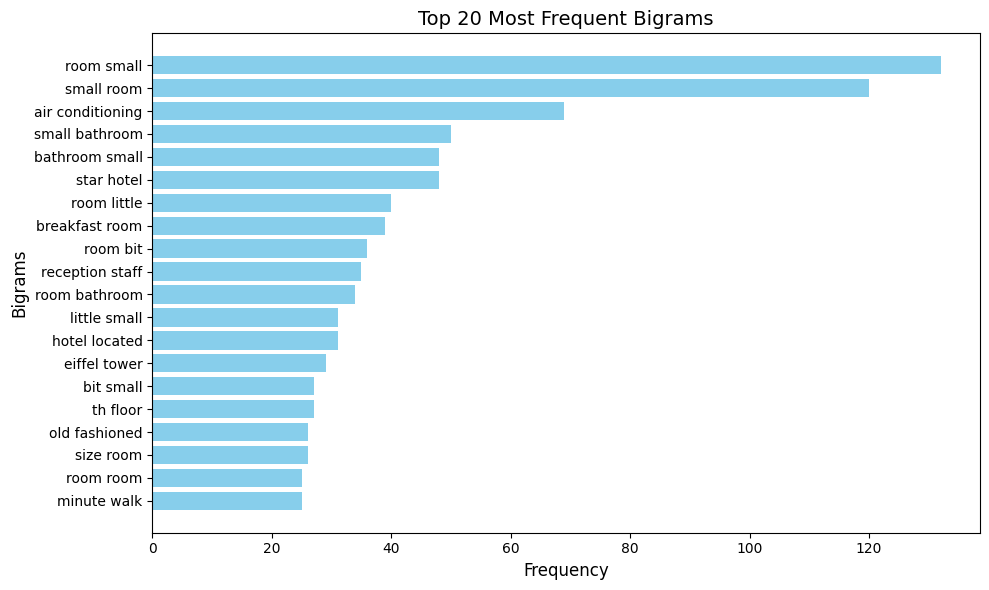

In [16]:
# Plot the top 20 bigrams
plt.figure(figsize=(10, 6))
plt.barh(bigram_df['Bigram'][::-1], bigram_df['Frequency'][::-1], color='skyblue')
plt.title('Top 20 Most Frequent Bigrams', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bigrams', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

### Clustering reviews using k-means algorithm

In [24]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

df['cluster'] = kmeans.labels_

for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i]['review'].head(5))


Cluster 0:
0    sound insulation hear neighbor especially step...
1                                  really small shower
2    room cleanliness hair bathroom wiper toilet di...
3    enjoyed everything happy try place disappointm...
4                        fruit breakfast example melon
Name: review, dtype: object
Cluster 1:
27             awake noise drill deactivating entry card
72     request change room night spent dark reduced s...
81     room overlooking course impossible open window...
105                           woke neighbor shower noise
106    room overlook interior courtyard ventilation s...
Name: review, dtype: object


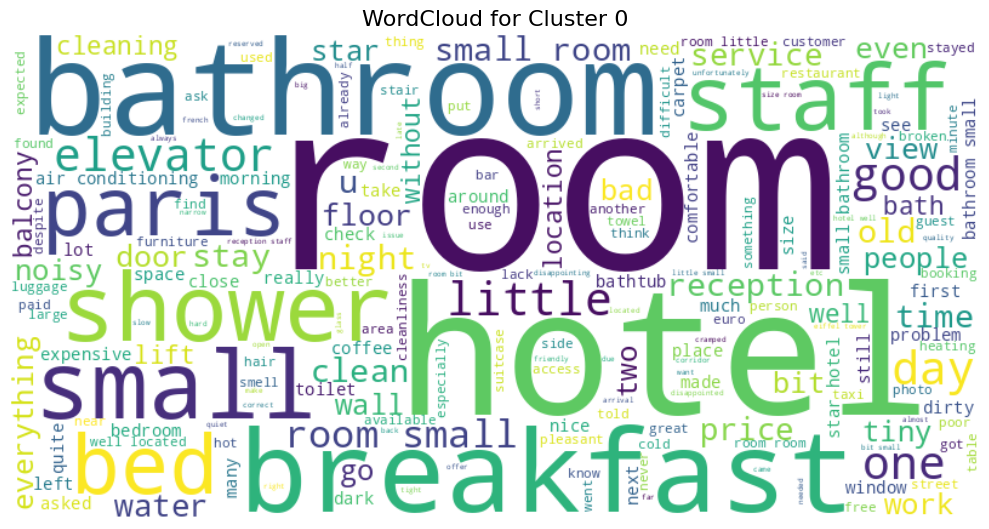

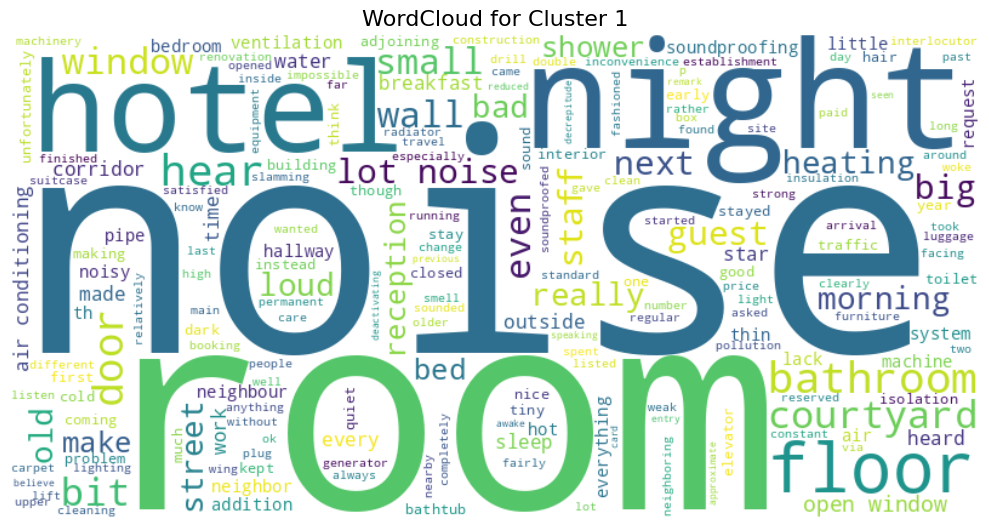

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming `df` contains a 'review' column and 'cluster' column from your clustering result

# Generate and display word clouds for each cluster
for i in range(num_clusters):
    cluster_reviews = " ".join(df[df['cluster'] == i]['review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_reviews)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Cluster {i}", fontsize=16)
    plt.tight_layout()
    plt.show()


<ipython-input-26-e4a9899b759b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='Score', data=cluster_scores, palette=palette)
<ipython-input-26-e4a9899b759b>:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x='cluster', y='Score', data=cluster_scores, palette=palette)


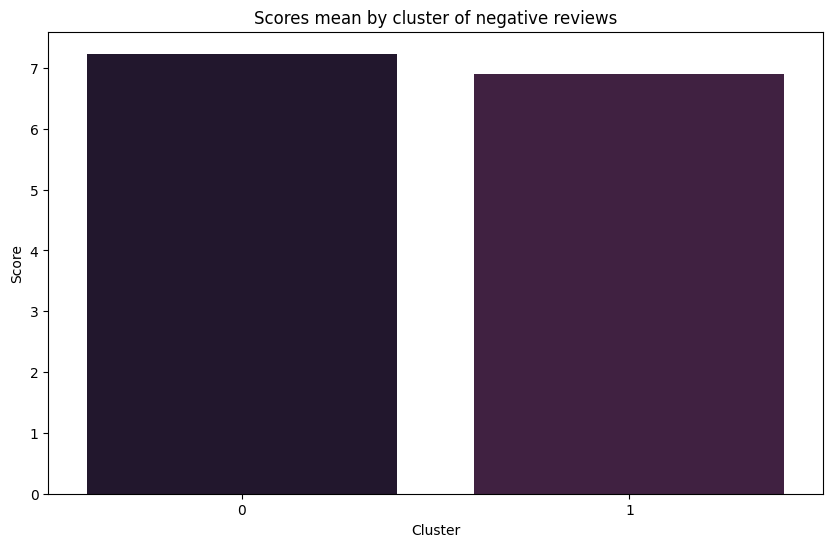

,word,avg_score
0,room,6.858824
1,small,6.960938
2,bathroom,6.683761
3,hotel,6.414573
4,breakfast,6.772109
5,little,7.735849
6,shower,6.803738
7,staff,6.303030
8,elevator,7.218750
9,old,6.074468


In [26]:
cluster_scores = df.groupby('cluster')['Score'].mean().reset_index()
palette = sns.color_palette("rocket", 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='Score', data=cluster_scores, palette=palette)
plt.title("Scores mean by cluster of negative reviews")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.show()

word_scores = []
for word, freq in words_freq[:20]:
    word_in_reviews = df['review'].str.contains(word)
    avg_score = df[word_in_reviews]['Score'].mean()
    word_scores.append((word, avg_score))

word_scores_df = pd.DataFrame(word_scores, columns=['word', 'avg_score'])
word_scored_df = word_scores_df.sort_values(by='avg_score', ascending=False)
word_scores_df.head(len(word_scores_df))


### In-depth Analysis: Why Do the Words 'Tiny,' 'Little,' and 'Small' Appear So Frequently?

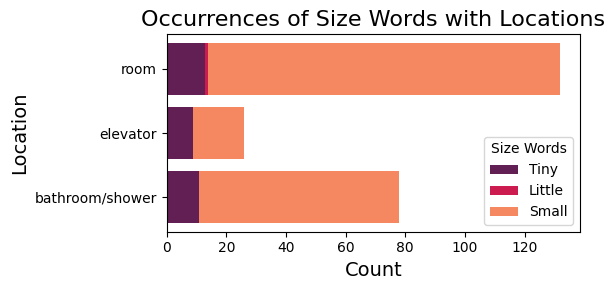

In [27]:
size_words = ['tiny', 'little', 'small']
location_words = ['elevator', 'bathroom', 'shower', 'room']

def count_word_combinations(text, size_word, location_word):
    pattern = re.compile(r'\b' + size_word + r'\s+' + location_word + r'\b', re.IGNORECASE)
    return len(pattern.findall(text))

word_counts = {size_word: {'bathroom/shower': 0, 'elevator': 0, 'room': 0} for size_word in size_words}

for review in df['review']:
    for size_word in size_words:
        for location_word in location_words:
            if location_word in ['bathroom', 'shower']:
                word_counts[size_word]['bathroom/shower'] += count_word_combinations(review, size_word, location_word)
            else:
                word_counts[size_word][location_word] += count_word_combinations(review, size_word, location_word)

word_counts_df = pd.DataFrame(word_counts)

palette = sns.color_palette("rocket", 3)

locations = word_counts_df.index
tiny_counts = word_counts_df['tiny']
little_counts = word_counts_df['little']
small_counts = word_counts_df['small']

plt.figure(figsize=(6, 3))

plt.barh(locations, tiny_counts, color=palette[0], label='Tiny')
plt.barh(locations, little_counts, left=tiny_counts, color=palette[1], label='Little')
plt.barh(locations, small_counts, left=tiny_counts + little_counts, color=palette[2], label='Small')

plt.title('Occurrences of Size Words with Locations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Location', fontsize=14)
plt.legend(title='Size Words')
plt.tight_layout()

plt.show()


We observe that the amount of reviews complaining on the smallness concern essentially the room, then the bathroom and we have finally some complains about the elevator.

In [ ]:
word_counts_df_t = word_counts_df.T
total_bathroom = word_counts_df_t['bathroom/shower'].sum()
total_elevator = word_counts_df_t['elevator'].sum()
total_room = word_counts_df_t['room'].sum()

total_list = pd.Series([total_bathroom, total_elevator, total_room], index=word_counts_df_t.columns)
word_counts_df_t.loc['Total'] = total_list
word_counts_df_t.head()

,bathroom/shower,elevator,room
tiny,11,9,13
little,0,0,1
small,67,17,118
Total,78,26,132


In [ ]:
size_words = ['tiny', 'little', 'small']
location_word = 'room'
pattern = r'\b(?:' + '|'.join(size_words) + r')\b.*\b' + location_word + r'\b'
matching_reviews = df[df['text'].str.contains(pattern, case=False, na=False)]

In [ ]:
review_examples = f"Here are 3 examples of reviews that complain on the size of the room : \
\n\t- '{matching_reviews['text'][6]}' \
\n\t- '{matching_reviews['text'][215]}' \
\n\t- '{matching_reviews['text'][97]}' \
"
print(review_examples)

Here are 3 examples of reviews that complain on the size of the room : 
	- 'The tiny room !!!!Impossible to enter 2 suitcases!' 
	- 'The very small room despite the choice of a superior room.The dilapidated air conditioning which does not cool' 
	- 'Very small room, 140cm bed and bathroom too and a little dated for a fairly high price' 


The word 'little' is used in order to measure the degree of complaint

In [ ]:
pattern = r'\blittle\b \bsmall\b'
df_little_small = df[df['review'].str.contains(pattern, case=False, na=False)]
print(f"Number of reviews containing 'little' with 'small': {df_little_small.shape[0]}")
df_little_small['text'].head()

Number of reviews containing 'little' with 'small': 31


,text
37,The shower a little small
71,Bad shower of the shower and reads a little small
95,Room: a little small\nBathroom: Ditto - Provid...
125,A little small bathroom with toilet in it.\nDi...
134,A little small but very functional bathroom


### Noise

In [33]:
noise_words = ['loud', 'noise', 'noisy', 'hear']
pattern = r'\b(?:' + '|'.join(noise_words) + r')\b'
matching_reviews_2 = df[df['text'].str.contains(pattern, case=False, na=False)]
matching_reviews_2[matching_reviews_2['Score'] < 7].head(15)


,Score,review,text,cluster
184,4,noisy bad sound insulation hear voice room nei...,"-very noisy, bad sound insulation, we hear the...",1
192,4,stayed night chbre cold bathroom broken radiat...,I stayed for 3 nights at CHBRE 601.\nIt is col...,1
201,4,quality bedding cleanliness soundproofing than...,The quality of bedding\nCleanliness\nSoundproo...,0
203,4,making reservation via site called establishme...,"After making the reservation via your site, I ...",1
205,5,bed size still sleep cm disput shower room spl...,"Bed size (which still sleeps in a 140cm?), Dis...",0
207,6,noise technical room interior courtyard make l...,The noise.Technical room in the interior court...,1
211,5,home sheet fill without taking time say hello ...,Home with a sheet to fill out without taking t...,0
218,4,star hotel disappointing despite spacious poor...,"For a 4 -star hotel it is disappointing, despi...",0
220,4,small bedroom bathroom noisy hotel,Too small bedroom and bathroom.Noisy hotel,0
226,3,welcome staff remains desired arrival room hug...,A welcome from the staff who remains to be des...,0


In [31]:
mean_score_noise = matching_reviews_2['Score'].mean()
mean_score_noise

6.700460829493087

### Summary of negative reviews

In [ ]:
from transformers import pipeline

reviews_text = " ".join(df['review'].tolist())
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
summary = summarizer(reviews_text, max_length=250, min_length=200, do_sample=False)

summary_text = summary[0]['summary_text']
summary_text

IndexError: index out of range in self

### Reviews by country

This part concerns only booking reviews as we didn't collect the country of residence of the clients on tripadvisor.

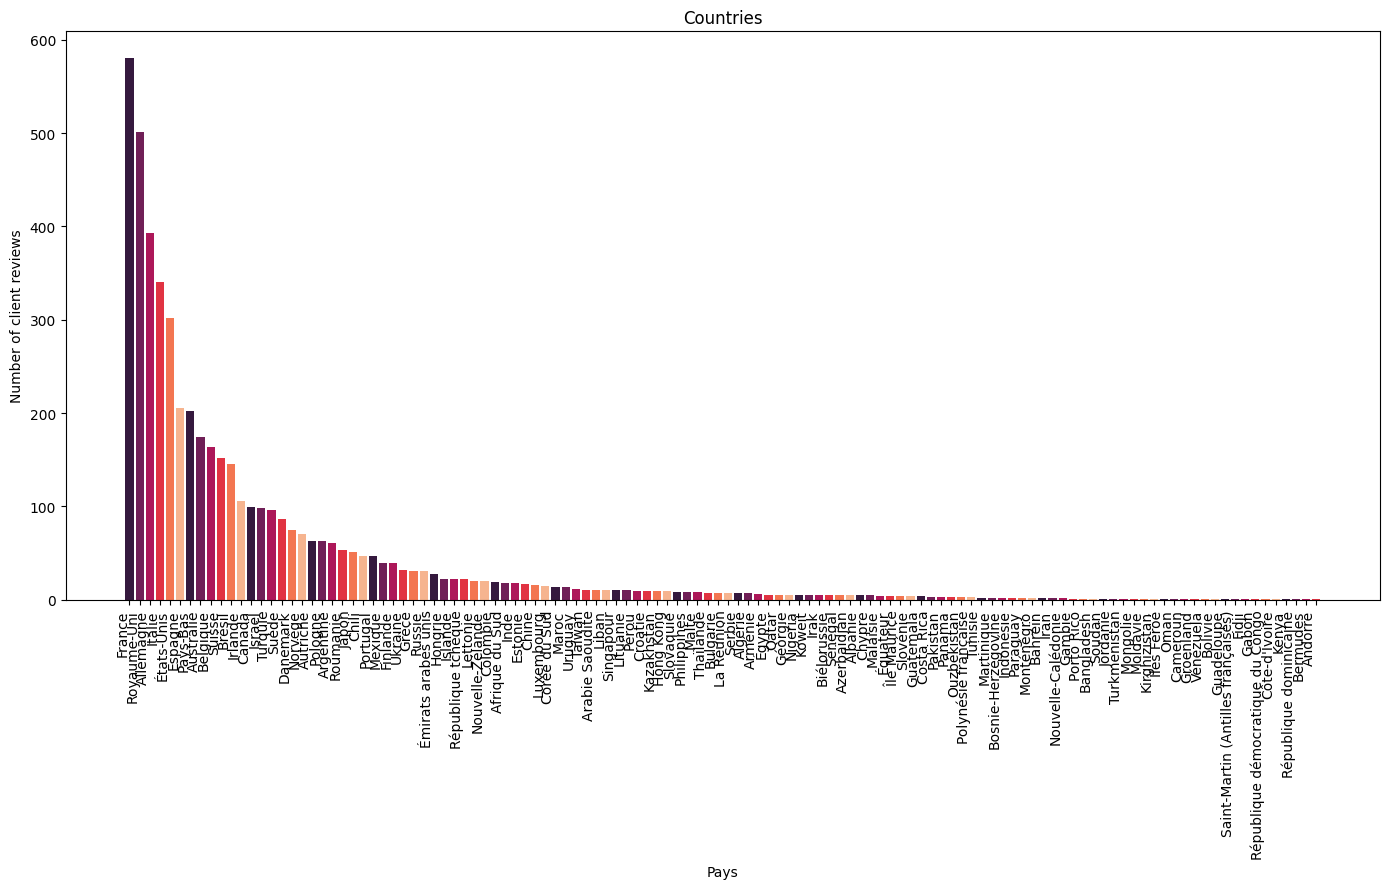

In [ ]:
country_count = df_raw['Country'].value_counts()
palette = sns.color_palette("rocket")
plt.figure(figsize=(14, 9))
plt.bar(country_count.index, country_count.values, color=palette)
plt.xlabel('Pays')
plt.ylabel('Number of client reviews')
plt.title('Countries')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


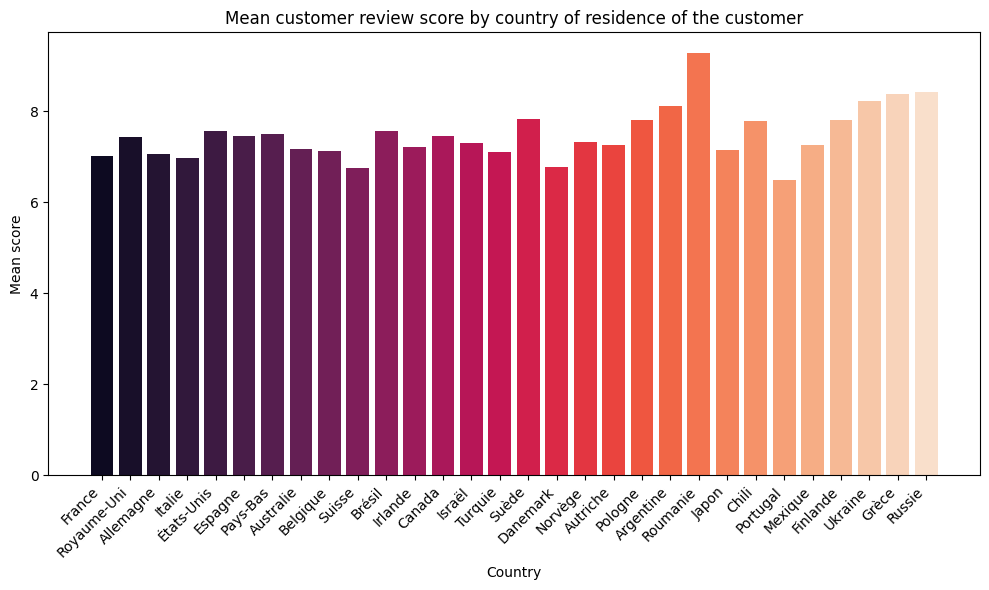

In [ ]:
min_amount_review_country = country_count[country_count > 30].index
df_country = df[df['Country'].isin(min_amount_review_country)]

country_score = df_country.groupby('Country')['Score'].mean()

country_score = country_score.loc[min_amount_review_country.intersection(country_score.index)]
palette = sns.color_palette("rocket", len(country_score))

plt.figure(figsize=(10, 6))
plt.bar(country_score.index, country_score.values, color=palette)
plt.xlabel('Country')
plt.ylabel('Mean score')
plt.title('Mean customer review score by country of residence of the customer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
country_score_sorted = country_score.sort_values(ascending=True)
print(f"3 countries with the weakest mean scores : \n{country_score_sorted.head(3)}")


3 countries with the weakest mean scores : 
Country
Portugal    6.500000
Suisse      6.746032
Danemark    6.766667
Name: Score, dtype: float64


In [ ]:
portuguese_reviews = df[df['Country'] == 'Portugal']['Translated_Neg']
for review in portuguese_reviews:
  print(review)


The reception staff is not very professional.
The room is tiny and does not have a storage cabinet.
The bed when we arrive was not very cleaned, with some hair and stains on the sheets
Difficult to stabilize the shower temperature
We thought the room was a little small yet it didn't interfere our experience as we walked around the city most of the day.
The air conditioner didn’t work very well and the city was hot in those days. They have to change all the fridges, terrible, didn’t work too.
Bedroom looked really tired and dated. Bathroom is extremely small and tub looking dirty and old needing to be replaced. Also super small and view was to a wall and airconditioner extractor! Also requested 4 days before my check in and during my stay and check out for the hotel invoice to be done with my company details and fiscal number and no one was Trained for that! Still waiting for that invoice until today! 5 days after and after severall messages through Booking to the Hotel with NO RESPONSE

In [ ]:
df.to_excel("sample_data/hotel_reviews_trianon_rive_gauche_cleaned.xlsx")